# 第三次作业

## 1.Householder 与Givens 在QR 分解中的比较


### (a)

由于在矩阵的计算之中，乘法的花销远比加法大，故只统计乘法的次数。

对于Householder方法，计算$R$主要是反复把$P_k$左乘到$A$上,$k=0,1,\cdots,n-2$，其中

$P_k=
\left[
\begin{matrix}
 1_k       & 0\\
 0       & R_{n-k} \\
\end{matrix}
\right]$


由于$P_k$的特殊性，矩阵乘法实际上只要计算一次矢量内积和一次矢量数乘，$P_k$乘以$A$乘法次数为$2n(n-k)$，总次数为$\sum_{k=0}^{n-2}2n(n-k)=(n-1) n (n+2)=O(n^3)$，计算$Q$时同样也是$O(n^3)$，总共$O(2n^3)$

对于Givens方法，计算$R$主要是把$G(i,k,\theta)$左乘到$A$上,每乘一次有$4n$次乘法，总共要乘$1+2+\cdots+n-1=\frac{1}{2}n(n-1)$次

故总次数为$2n^2(n-1)=O(2n^3)$，同样计算$Q$为$O(2n^3)$，总共$O(4n^3)$

### (b)

Household 算法代码如下：

In [1]:
import numpy as np
from numba import jit 


# Household 算法
# 符号取与教材类似
# 由x,m求v,0<=m<n
def clv(x, m):
    xt = np.copy(x)
    xt[m] += np.linalg.norm(x)
    return xt


# 利用矢量相乘的方法计算P_k点乘一个矩阵，实现算法复杂度的降低
# dim(w)=n-k
def dotP(n, k, w, A):
    if A.shape[0] != n:
        print('error')
    else:
        a = np.copy(A)
        m = a.shape[1]
        normw2 = np.linalg.norm(w) ** 2
        for i in range(0, m):
            a[k:n, i] = a[k:n, i] - 2 / normw2 * np.dot(w, a[k:n, i]) * w
        return a


def QRHessenberg(A):
    n = A.shape[0]
    Q = np.identity(n)
    R = np.copy(A)
    for i in range(0, n-1):
        w = clv(R[i:n, i],0)
        Q = dotP(n, i, w, Q)
        R = dotP(n, i, w, R)
    return (np.transpose(Q), R)


In [2]:
# test
a = np.array([[1., 2, 3, 4], [1, 2, 4, 1], [2, 7, 2, 1], [10, 3, 4, 1.]])
print(QRHessenberg(a))

(array([[-0.09712859, -0.23254763, -0.5151677 ,  0.81920075],
       [-0.09712859, -0.23254763, -0.78237607, -0.56953957],
       [-0.19425717, -0.91601078,  0.34466007, -0.06631625],
       [-0.97128586,  0.22971168,  0.06082236, -0.01170287]]), array([[ -1.02956301e+01,  -4.66217214e+00,  -4.95355790e+00,
         -1.65118597e+00],
       [  5.55970637e-16,  -6.65313091e+00,  -2.54100823e+00,
         -1.84903724e+00],
       [  9.33183787e-16,  -2.24260833e-15,  -3.74239781e+00,
         -2.43756446e+00],
       [ -1.42728345e-15,  -1.96096737e-15,  -1.11022302e-16,
          2.62924432e+00]]))


### (c)

Givens算法如下：

In [3]:
# G(i,k,theta)
def Gik(i, k, n, xi, xk):
    g = np.identity(n, dtype=float)
    norm = np.sqrt(xi ** 2 + xk ** 2)
    sint = xk / norm
    cost = xi / norm
    g[i, i] = g[k, k] = cost
    g[i, k] = sint
    g[k, i] = -sint
    return g


def QRGivens(A):
    n = A.shape[0]
    Q = np.identity(n)
    R = np.copy(A)
    for i in range(n - 1, 0, -1):
        for j in range(0, n - i):
            ii = i + j  # ii,j为Givens矩阵的左下角对应于A的index
            g = Gik(ii - 1, ii, n, R[ii - 1, j], R[ii, j])
            Q = np.dot(g, Q)
            R = np.dot(g, R)
    return (np.transpose(Q), R)

In [4]:
# test
a = np.array([[1., 2, 3, 4], [1, 2, 4, 1], [2, 7, 2, 1], [10, 3, 4, 1.]])
print(QRGivens(a))

(array([[ 0.09712859,  0.23254763,  0.5151677 ,  0.81920075],
       [ 0.09712859,  0.23254763,  0.78237607, -0.56953957],
       [ 0.19425717,  0.91601078, -0.34466007, -0.06631625],
       [ 0.97128586, -0.22971168, -0.06082236, -0.01170287]]), array([[ 10.29563014,   4.66217214,   4.9535579 ,   1.65118597],
       [  0.        ,   6.65313091,   2.54100823,   1.84903724],
       [  0.        ,   0.        ,   3.74239781,   2.43756446],
       [  0.        ,   0.        ,   0.        ,   2.62924432]]))


### (d)

测试如下：

In [5]:
import time
timeHousehold=[]
timeGivens=[]
for i in range(0,20):
    a=2*np.random.random((6,6))-1
    tic1=time.clock()
    QRHessenberg(a)
    toc1=time.clock()
    timeHousehold.append(toc1-tic1)
    tic2=time.clock()
    QRGivens(a)
    toc2=time.clock()
    timeGivens.append(toc2-tic2)

时间列表如下：

In [6]:
import pandas as pd
pd.DataFrame({'Household':timeHousehold,
             'Givens':timeGivens})

,Givens,Household
0,0.000386,0.001585
1,0.000463,0.001342
2,0.000179,0.000688
3,0.000203,0.000589
4,0.000503,0.000455
5,0.000761,0.001207
6,0.000186,0.000998
7,0.000176,0.000533
8,0.000168,0.000407
9,0.000209,0.000715


绘图如下：

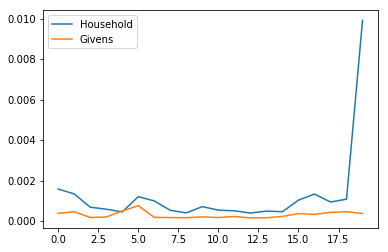

In [7]:
from matplotlib import pyplot as plt
plt.figure
plt.plot(timeHousehold,label='Household')
plt.plot(timeGivens,label='Givens')
plt.legend(loc=0)
plt.show()

可以看出，对于较小的n (n=6)来说，Household方法比Givens方法要来得慢。

## 2. 幂次法求矩阵最大模的本征值和本征矢

### (a)

由$\ddot{x}=-A\cdot x$，有$\ddot{x_i}=-A_{ij}x_j$，带入$x=Xe^{-i\omega t}$，有

$-\omega^2X_ie^{-i\omega t}=-A_{ij}X_je^{-i\omega t}$,$A_{ij}X_j=\omega^2X_i$

所以$A\cdot X=\lambda X,\lambda=\omega^2$

### (b)

证明：

设$q^{(0)}=\sum_{i=1}^na_iv_i$，$a_1\neq0,v_i$为A的单位正交基矢，$Av_i=\lambda_i v_i$

则由$z^{(k+1)}=A\cdot q^{(k)}=\frac{Az^{(k)}}{||z^{(k)}||}$，$z^{(0)}=q^{(0)}$知

$z^{(m)}=\frac{A^mq^{(0)}}{\Pi_{k=1}^{m-1}||z^{(k)}||}=\frac{A^m\sum_{i=1}^na_iv_i}{\Pi_{k=1}^{m-1}||z^{(k)}||}
=\frac{\sum_{i=1}^na_iA^mv_i}{\Pi_{k=1}^{m-1}||z^{(k)}||}=\frac{\sum_{i=1}^na_i\lambda_i^mv_i}{\Pi_{k=1}^{m-1}||z^{(k)}||}
=$

$=\sum_{i=1}^n\frac{a_i \lambda_1^m}{\Pi_{k=1}^{m-1}||z^{(k)}||}\cdot(\frac{\lambda_i}{\lambda_1})^mv_i$

当$m\to\infty$时，由算法知$z^(m)$是有界的，故$\frac{a_i \lambda_1^m}{\Pi_{k=1}^{m-1}||z^{(k)}||}$是有界的，取极限有

$\lim_{m\to\infty}z^{(m)}=\sum_{i=1}^n\lim_{m\to\infty}\frac{a_i \lambda_1^m}{\Pi_{k=1}^{m-1}||z^{(k)}||}\cdot\lim_{m\to\infty}(\frac{\lambda_i}{\lambda_1})^mv_i
=\lim_{m\to\infty}\frac{a_i \lambda_1^m}{\Pi_{k=1}^{m-1}||z^{(k)}||}\cdot v_1$

故$\lim_{m\to\infty}q^{(m)}=\lim_{m\to\infty}\frac{z^{(m)}}{||z^{(m)}||}=v_1$

从而$\lim_{m\to\infty}\nu_m=\lim_{m\to\infty}[q^{(m)}]^\dagger Aq^{(m)}=[v_1]^\dagger Av_1=\lambda_1[v_1]^\dagger v_1=\lambda_1$

对于N=10，计算代码和结果如下：

In [8]:
def genA(n):
    a = np.zeros((n, n), dtype=float)
    for i in range(0, n - 1):
        a[i, i] = 2
        a[i, i + 1] = -1
        a[i + 1, i] = -1
    a[n - 1, n - 1] = 2
    return a


def calcA(A):
    n = A.shape[0]
    q = np.random.random((n, 1))
    q = 1 / np.linalg.norm(q) * q
    qq = np.zeros((n, 1))
    z = np.copy(q)
    while np.linalg.norm(qq - q) > 1e-8:
        qq = np.copy(q)
        z = np.dot(A, q)
        q = 1 / np.linalg.norm(z) * z
    return (q.reshape(n), np.transpose(q).dot(A).dot(q)[0,0])


print(calcA(genA(10)))


(array([ 0.1201312 , -0.23053008,  0.32225276, -0.38786843,  0.4220613 ,
       -0.42206126,  0.38786834, -0.32225264,  0.23052996, -0.12013113]), 3.9189859472289896)
